# 0.0 Imports


In [582]:
import numpy  as np
import pandas as pd
import inflection
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn  import linear_model    as lm
from sklearn  import model_selection as ms
from sklearn  import ensemble        as en
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

## 0.1 Helper Functions

In [2]:
def rescalin_mms_train(df, columns_minmax,mms):        
    for column in columns_minmax:
        df[column] = mms.fit_transform(df[[column]].values)
    return df

def rescaling_mms_test(df, columns_minmax, mms_dict):
    for column in columns_minmax:
        df[column] = mms.transform(df[[column]].values)
    return df

## 0.2 Loading Dataset

In [3]:
df0 = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

# 1.0 Data Description

In [4]:
df1 = df0.copy()

## 1.1 Rename Columns

In [5]:
cols_old = ['id', 'Time', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'feat6',
       'feat7', 'feat8', 'feat9', 'feat10', 'feat11', 'feat12', 'feat13',
       'feat14', 'feat15', 'feat16', 'feat17', 'feat18', 'feat19', 'feat20',
       'feat21', 'feat22', 'feat23', 'feat24', 'feat25', 'feat26', 'feat27',
       'feat28', 'Transaction_Amount', 'IsFraud']

snakecase = lambda x: inflection.underscore (x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

In [6]:
cols_old = ['id', 'Time', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'feat6',
       'feat7', 'feat8', 'feat9', 'feat10', 'feat11', 'feat12', 'feat13',
       'feat14', 'feat15', 'feat16', 'feat17', 'feat18', 'feat19', 'feat20',
       'feat21', 'feat22', 'feat23', 'feat24', 'feat25', 'feat26', 'feat27',
       'feat28', 'Transaction_Amount']

snakecase = lambda x: inflection.underscore (x)

cols_new = list(map(snakecase, cols_old))

#rename
df_test.columns = cols_new

## 1.2 Data Dimension

In [7]:
print ('Number of Rows: {}'.format(df1.shape[0]))
print ('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 150000
Number of Columns: 32


## 1.3 Data Types

In [8]:
df1.dtypes

id                      int64
time                  float64
feat1                 float64
feat2                 float64
feat3                 float64
feat4                 float64
feat5                 float64
feat6                 float64
feat7                 float64
feat8                 float64
feat9                 float64
feat10                float64
feat11                float64
feat12                float64
feat13                float64
feat14                float64
feat15                float64
feat16                float64
feat17                float64
feat18                float64
feat19                float64
feat20                float64
feat21                float64
feat22                float64
feat23                float64
feat24                float64
feat25                float64
feat26                float64
feat27                float64
feat28                float64
transaction_amount    float64
is_fraud                int64
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

id                    0
time                  0
feat1                 0
feat2                 0
feat3                 0
feat4                 0
feat5                 0
feat6                 0
feat7                 0
feat8                 0
feat9                 0
feat10                0
feat11                0
feat12                0
feat13                0
feat14                0
feat15                0
feat16                0
feat17                0
feat18                0
feat19                0
feat20                0
feat21                0
feat22                0
feat23                0
feat24                0
feat25                0
feat26                0
feat27                0
feat28                0
transaction_amount    0
is_fraud              0
dtype: int64

## 1.5 Data Descriptive

In [10]:
num_attributes = df1.select_dtypes(include=['int64','float64'])

In [11]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.000000,149999.000000,149999.000000,74999.500000,74999.500000,43301.270188,0.000000,-1.200000
1,time,0.000000,73899.000000,73899.000000,49785.422340,53785.000000,18733.593164,-1.022917,0.438585
2,feat1,-22.173926,2.390816,24.564743,0.069456,0.671327,1.346548,-1.898707,11.876868
3,feat2,-44.247914,16.068473,60.316387,-0.003674,0.003677,1.161498,-2.443150,46.943760
4,feat3,-19.088980,6.145578,25.234557,0.739860,0.826497,1.012798,-1.519486,13.568800
5,feat4,-5.069484,12.547997,17.617481,0.104810,0.095342,1.230905,0.095773,0.301804
6,feat5,-21.090735,34.581260,55.671995,-0.254623,-0.322525,1.048265,0.893436,22.209336
7,feat6,-25.659750,15.082516,40.742266,0.151934,-0.068690,1.182960,1.411585,5.447317
8,feat7,-31.179799,23.256066,54.435865,-0.165443,-0.144551,0.802665,-0.895074,44.863505
9,feat8,-28.903442,18.270586,47.174028,0.166254,0.125052,0.691264,-6.960278,206.970515


# 2.0 Feature Engineering

In [1347]:
df2 = df1.copy()

# 3.0 Data Filtering

In [1491]:
df3 = df2.copy()

In [1492]:
df3 = df3[(df3['transaction_amount'] < 650)]

In [1468]:
df3.shape

(148433, 32)

# 4.0 Exploratory Data Analysis


In [1496]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


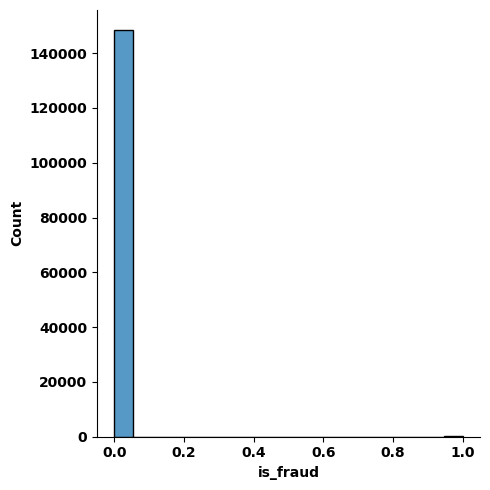

In [19]:
#df_aux = df5[(df5['casos_de_dengue'] > 1000)]
sns.displot(df4['is_fraud'])

In [20]:
df4['is_fraud'].value_counts()

is_fraud
0    148340
1       235
Name: count, dtype: int64

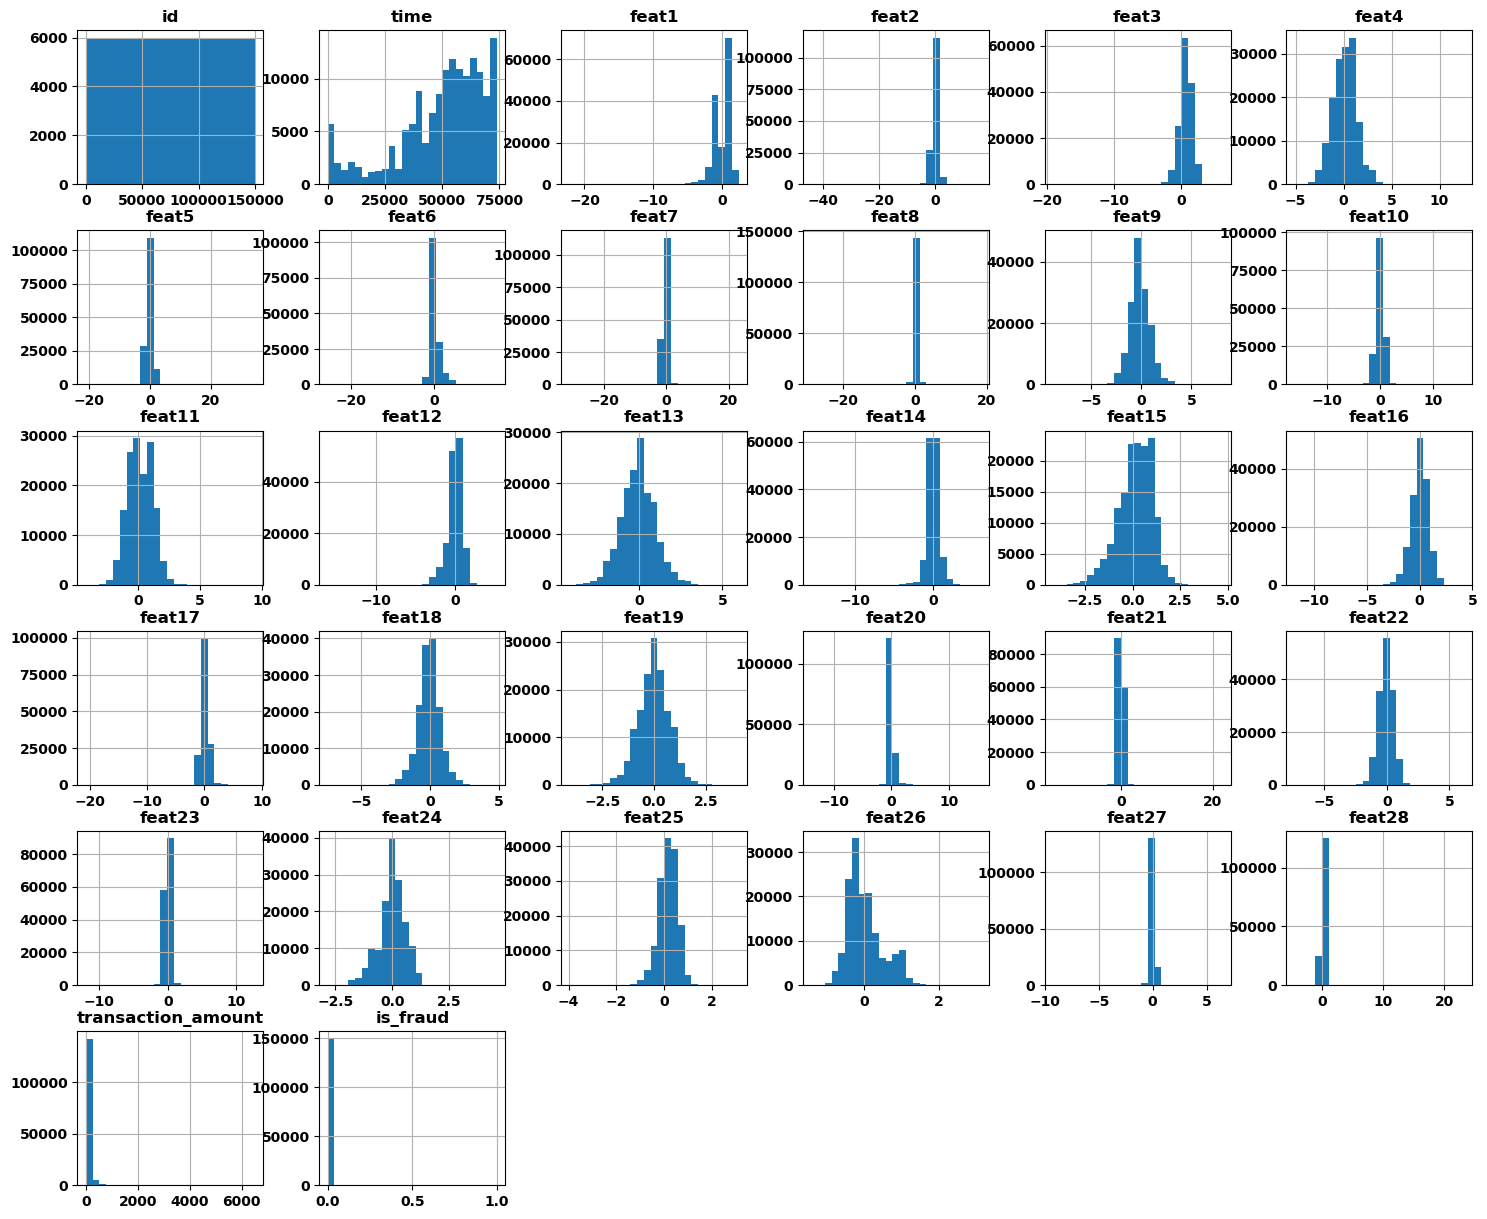

In [21]:
num_attributes.hist(bins=25, figsize=(18, 15));


c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


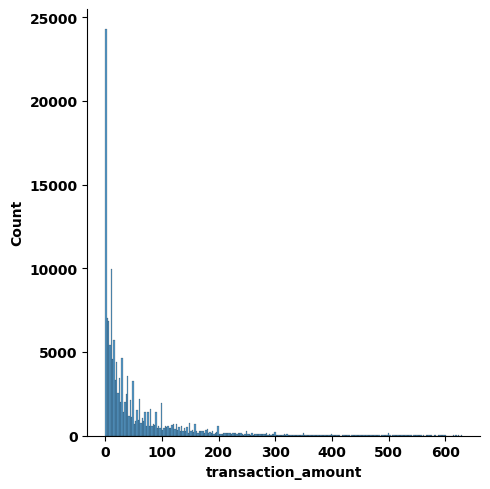

In [1588]:
# transaction_amount
sns.displot(df4['transaction_amount'])

In [1611]:
df2.loc[:, ['transaction_amount','is_fraud']].groupby('is_fraud').mean().reset_index()

,is_fraud,transaction_amount
0,0,70.934880
1,1,143.600558


In [1613]:
df2['transaction_amount'].mean()

71.06519361435043

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


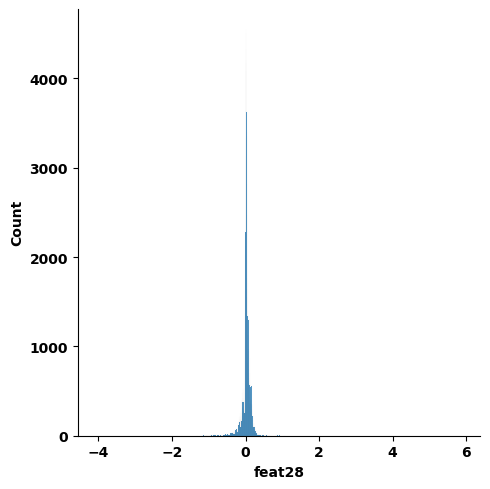

In [1589]:
#feat28
sns.displot(df4['feat28'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


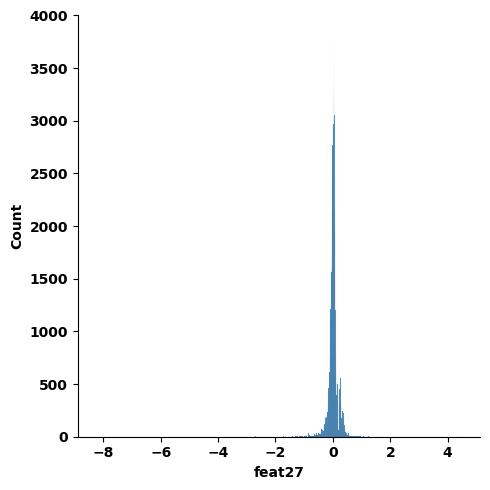

In [1590]:
#feat27
sns.displot(df4['feat27'])

<Axes: xlabel='is_fraud', ylabel='feat26'>

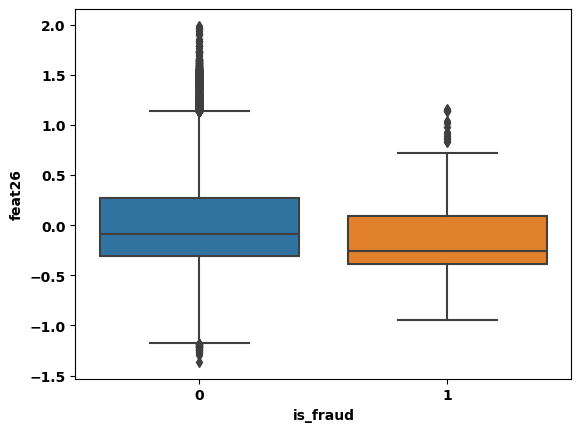

In [25]:
# feat26
sns.boxplot(x='is_fraud', y='feat26',data=df4)

<Axes: xlabel='is_fraud', ylabel='feat25'>

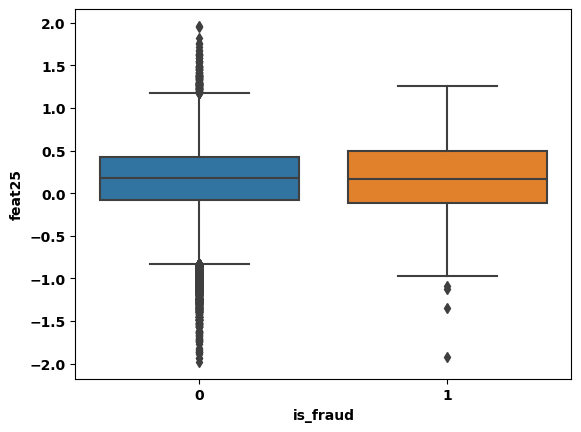

In [26]:
# feat25
sns.boxplot(x='is_fraud', y='feat25',data=df4)

<Axes: xlabel='is_fraud', ylabel='feat24'>

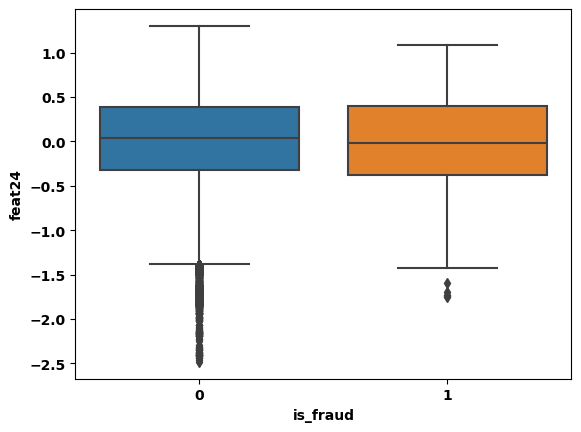

In [27]:
# feat24
sns.boxplot(x='is_fraud', y='feat24',data=df4)

<Axes: xlabel='is_fraud', ylabel='feat23'>

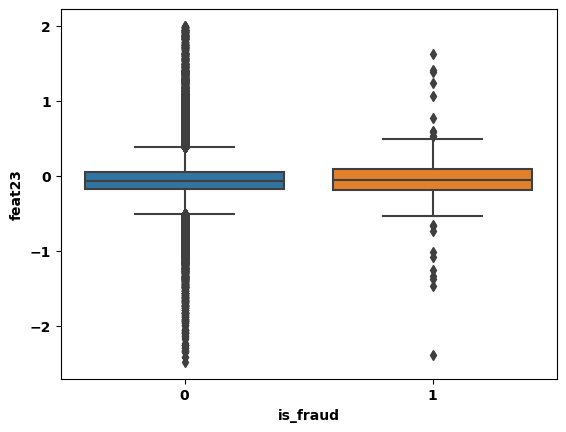

In [28]:
# feat23
sns.boxplot(x='is_fraud', y='feat23',data=df4)

<Axes: xlabel='is_fraud', ylabel='feat22'>

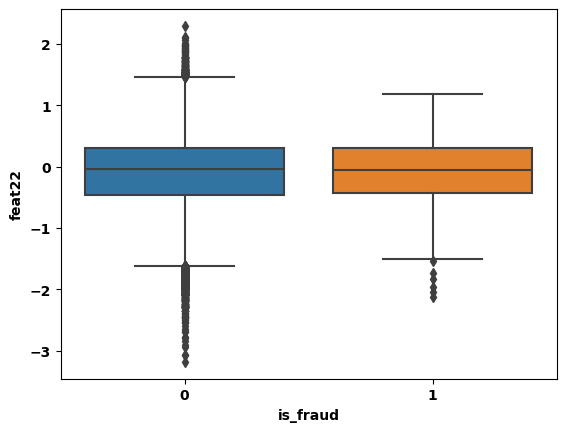

In [29]:
# feat22
sns.boxplot(x='is_fraud', y='feat22',data=df4)

<Axes: xlabel='is_fraud', ylabel='feat21'>

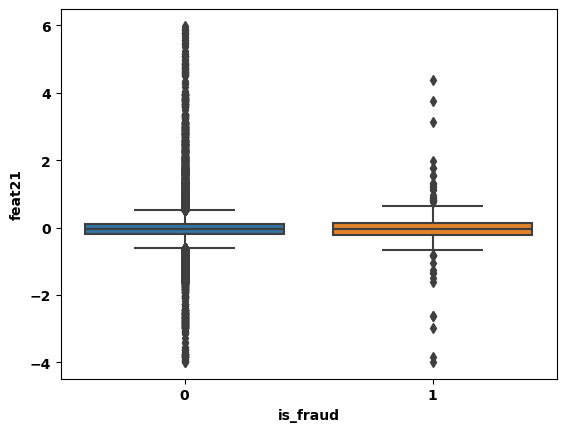

In [30]:
# feat21
sns.boxplot(x='is_fraud', y='feat21',data=df4)

<Axes: xlabel='is_fraud', ylabel='feat20'>

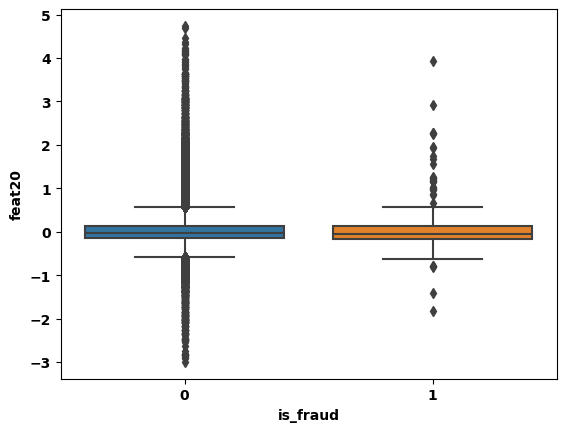

In [31]:
# feat20
sns.boxplot(x='is_fraud', y='feat20',data=df4)

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


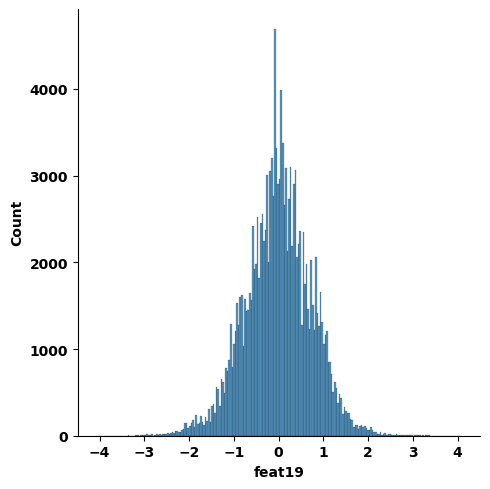

In [1591]:
sns.displot(df4['feat19'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


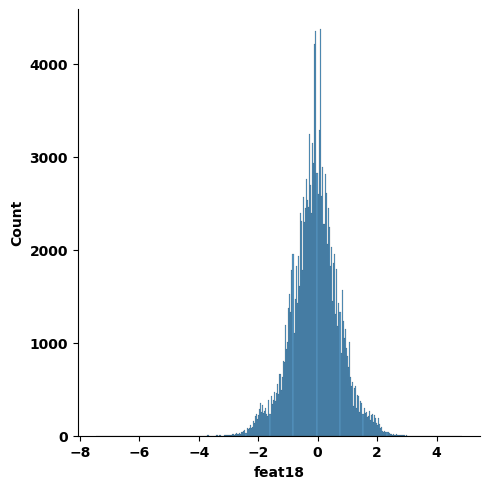

In [1592]:
sns.displot(df4['feat18'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


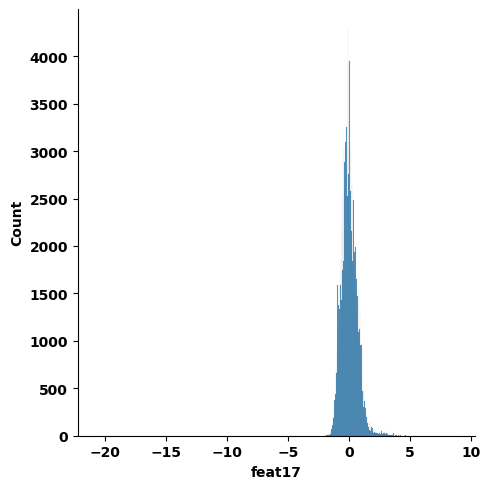

In [1593]:
sns.displot(df4['feat17'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


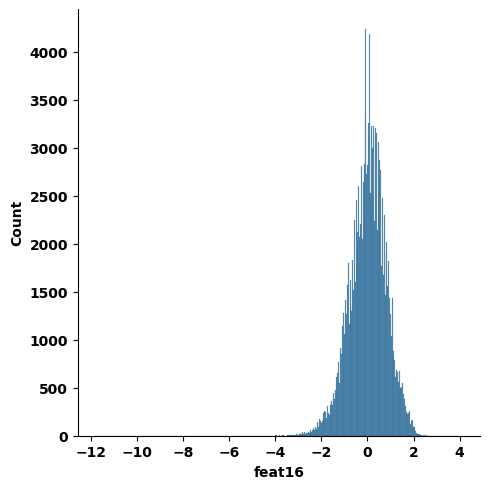

In [1594]:
sns.displot(df4['feat16'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


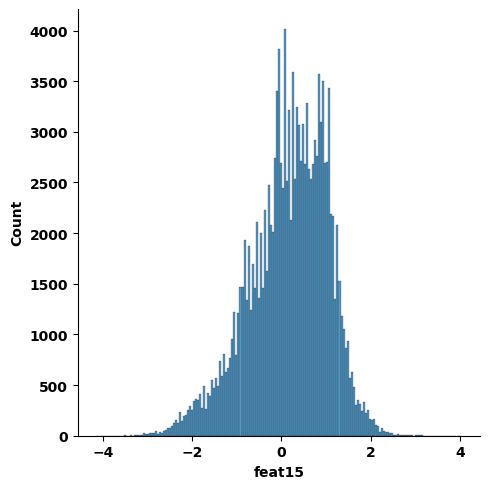

In [1595]:
sns.displot(df4['feat15'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


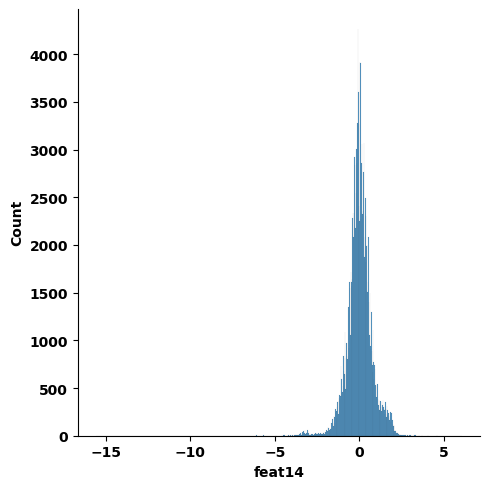

In [1596]:
sns.displot(df4['feat14'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


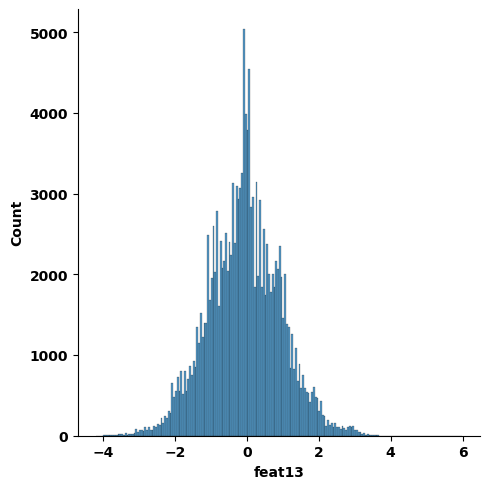

In [1597]:
sns.displot(df4['feat13'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


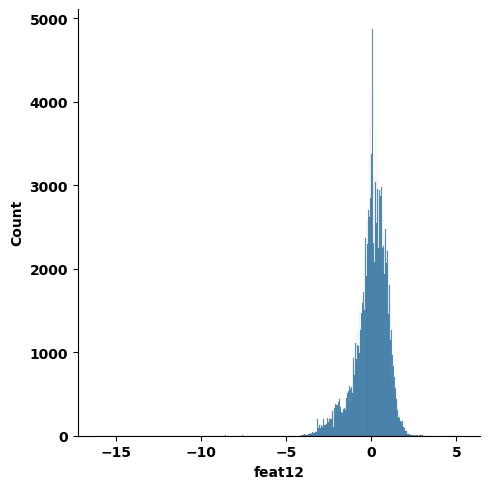

In [1598]:
sns.displot(df4['feat12'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


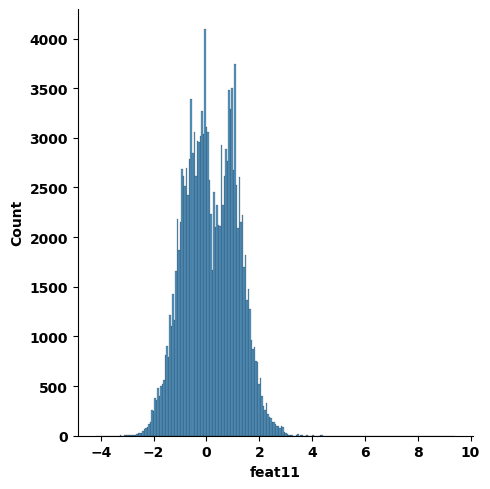

In [1599]:
sns.displot(df4['feat11'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


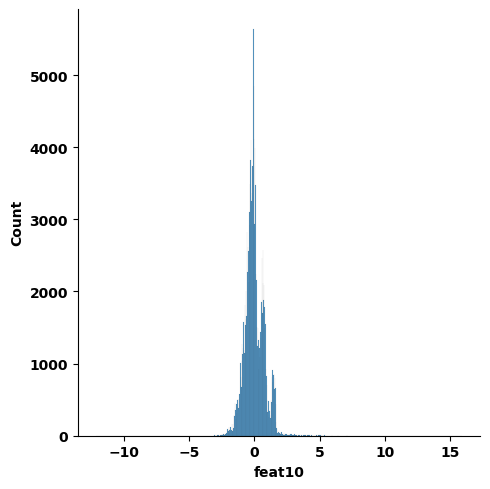

In [1600]:
sns.displot(df4['feat10'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


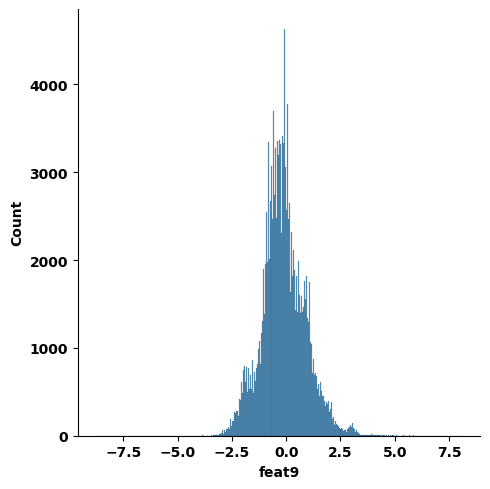

In [1601]:
sns.displot(df4['feat9'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


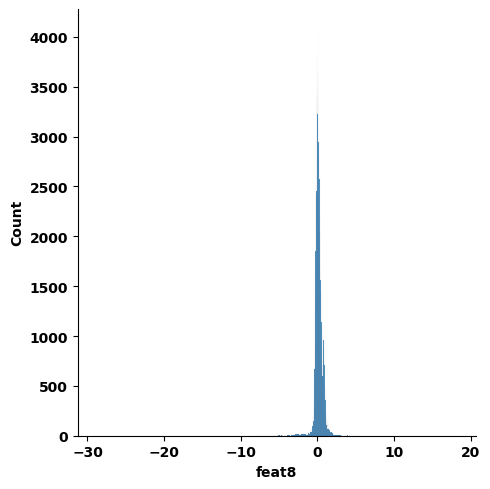

In [1602]:
sns.displot(df4['feat8'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


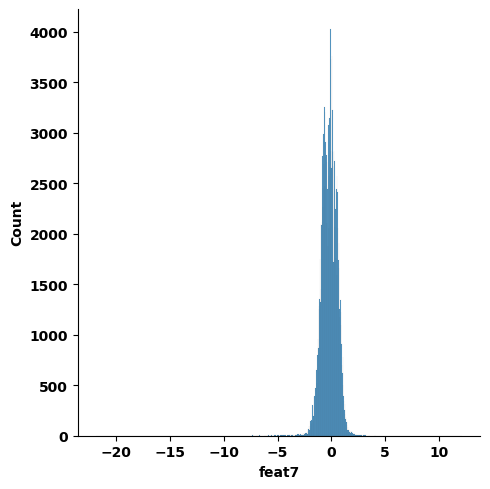

In [1603]:
sns.displot(df4['feat7'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


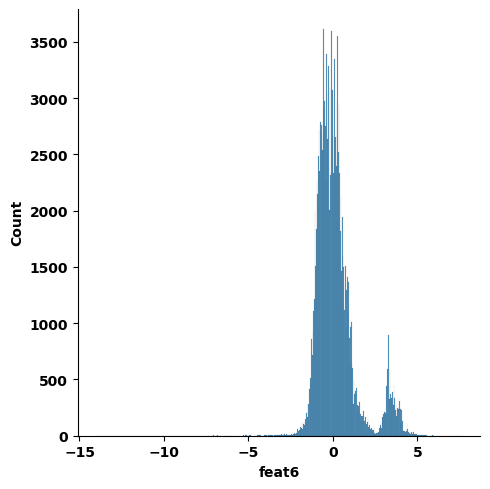

In [1604]:
sns.displot(df4['feat6'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


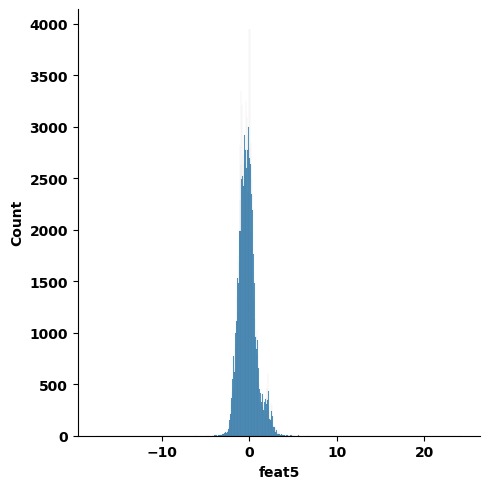

In [1605]:
sns.displot(df4['feat5'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


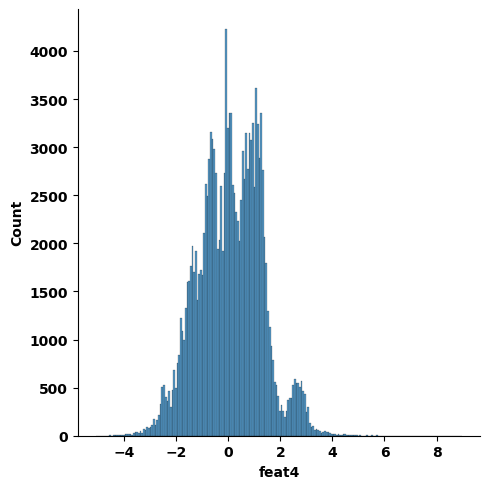

In [1606]:
sns.displot(df4['feat4'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


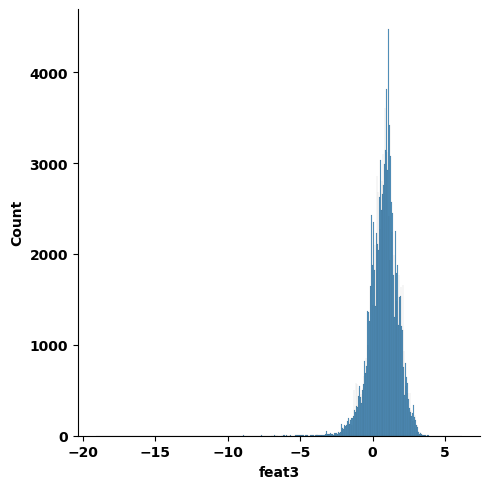

In [1607]:
sns.displot(df4['feat3'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


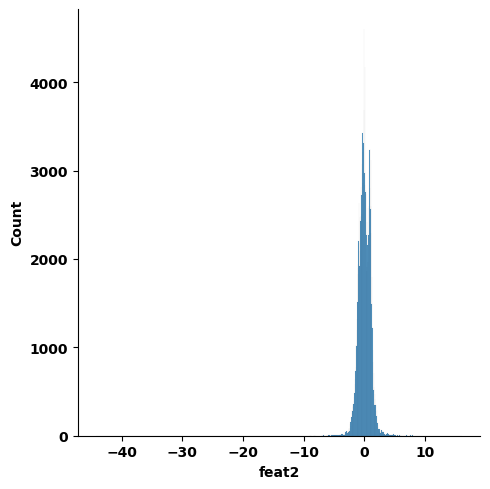

In [1608]:
sns.displot(df4['feat2'])

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


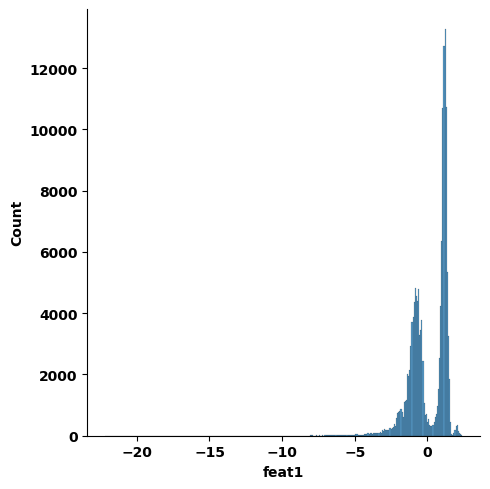

In [1609]:
sns.displot(df4['feat1'])

# 5.0 Data Preparation

In [1497]:
df5 = df4.copy()

In [1498]:
df5 = df5.drop(['id','time'], axis =1)

## 5.1 Split train and validation

In [1499]:
x = df5.drop('is_fraud', axis=1)
y = df5['is_fraud'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( x, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

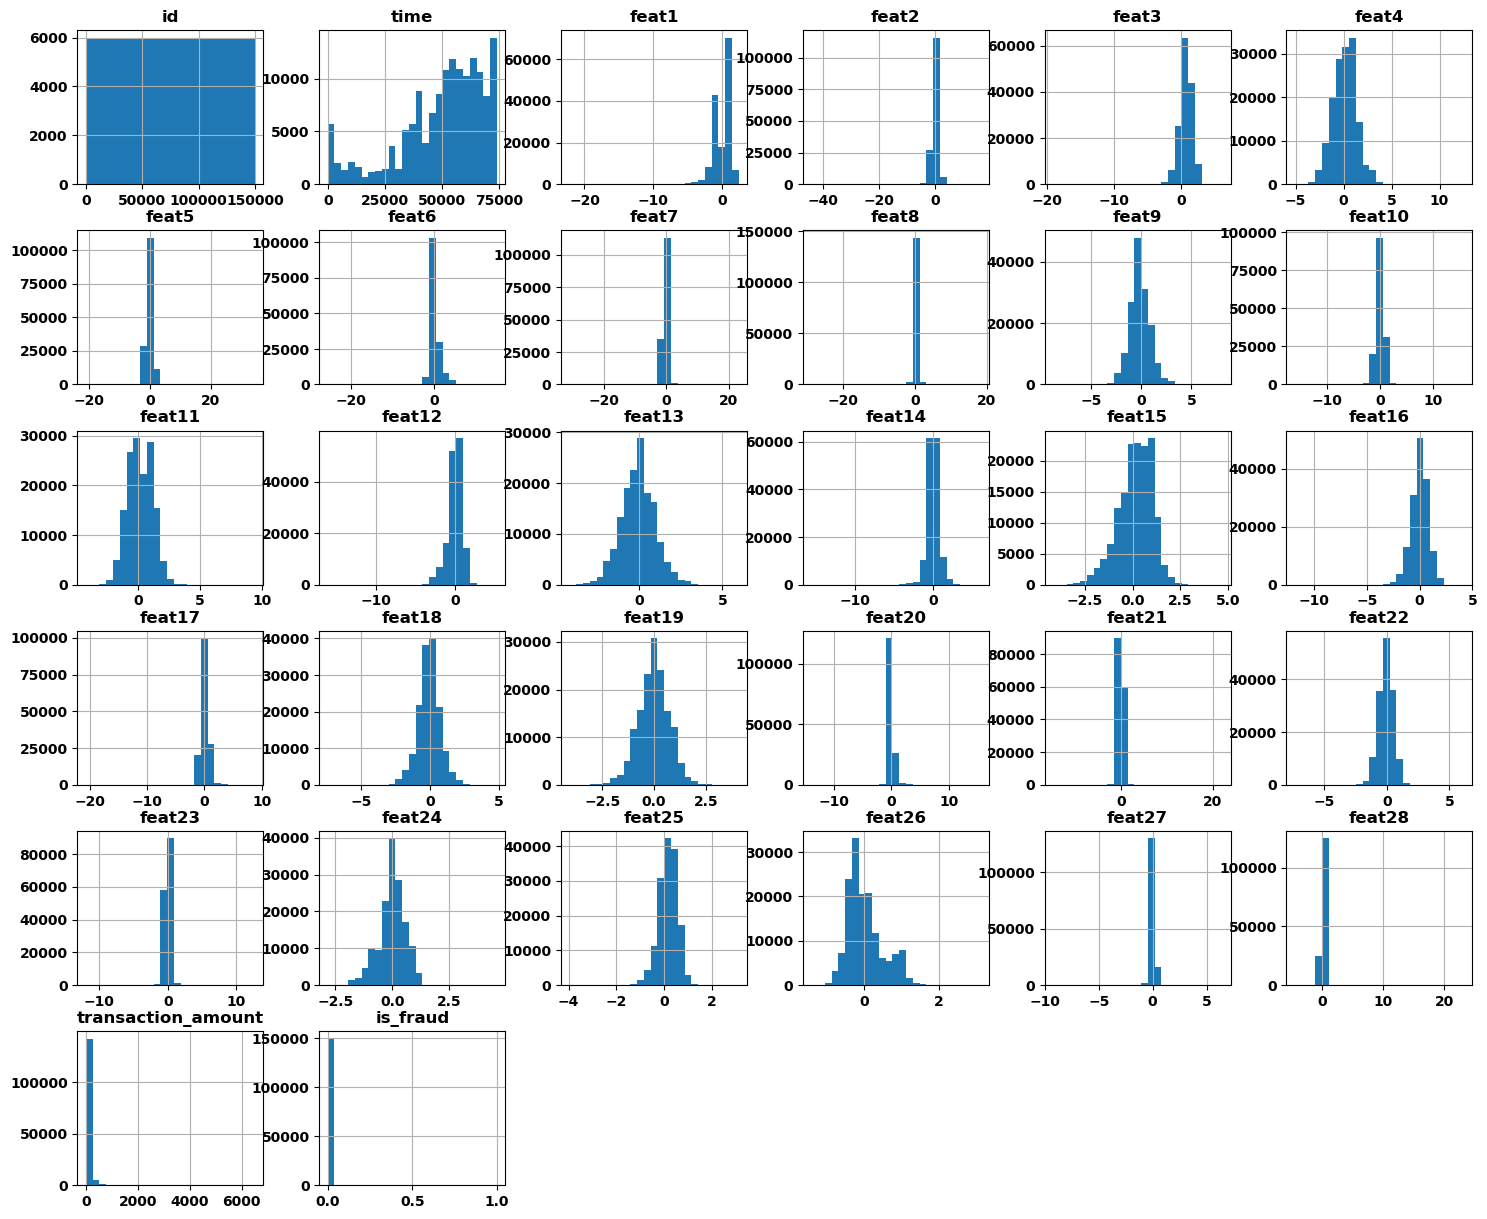

In [35]:
num_attributes.hist(bins=25, figsize=(18, 15));

## 5.3 Rescaling

In [1500]:

mms = MinMaxScaler()   
df5 = rescalin_mms_train(df5,['transaction_amount',],ss)

## 5.4. Validation Preparation

In [1501]:
mms = MinMaxScaler()   
x_validation = rescalin_mms_train(x_validation,['transaction_amount'],ss)

## 5.5 Train Preparation

In [1502]:
x_train = df5.drop('is_fraud', axis =1)
y_train = df5['is_fraud']

# 6.0 Feature Selection

In [1232]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=150, random_state=0, n_jobs=-1 )

forest.fit( x_train, y_train )

ExtraTreesClassifier(n_estimators=150, n_jobs=-1, random_state=0)

Feature ranking:
              feature  importance
0              feat13    0.039100
0              feat21    0.038510
0              feat12    0.037258
0              feat18    0.037107
0               feat3    0.036087
0              feat14    0.035657
0              feat20    0.035408
0              feat22    0.035226
0              feat17    0.035168
0               feat7    0.034806
0              feat15    0.034698
0               feat5    0.034670
0              feat19    0.034249
0               feat9    0.034173
0              feat16    0.034130
0              feat23    0.034128
0              feat11    0.034092
0               feat8    0.034077
0               feat4    0.034046
0              feat26    0.033855
0              feat10    0.033837
0              feat25    0.033811
0              feat24    0.033278
0              feat28    0.033106
0               feat6    0.032922
0              feat27    0.032869
0               feat2    0.032296
0               feat1    0.0312

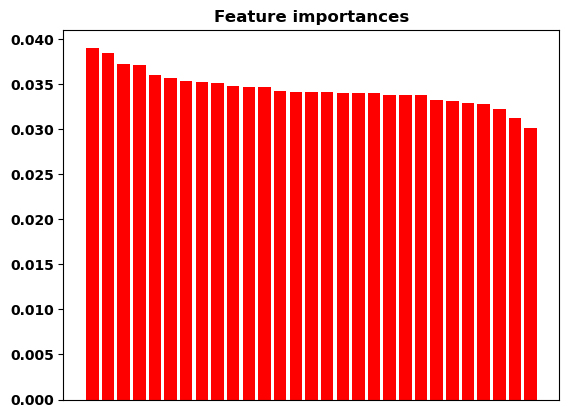

In [898]:
importances = forest.feature_importances_

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train, importances):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 ).sort_values( 'importance', ascending=False )
    
print( df )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(x= df['feature'], height=df['importance'],data=df,color="r")
plt.xticks([])
plt.show()

# 7.0 Machine Learning Moddeling

## 7.1 Random Forest Regressor

In [1503]:
# model definition
rf = en.RandomForestClassifier( n_estimators=90,max_depth=8, n_jobs=-1, random_state=42 ) 

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = rf.predict_proba( x_validation )


In [1565]:
threshold = 0.12
y_pred_binary_rf = (yhat_rf[:,1] > threshold).astype(int)

# Calcular precisão e recall
precision = precision_score(y_validation, y_pred_binary_rf)
recall = recall_score(y_validation, y_pred_binary_rf)
roc_auc = roc_auc_score(y_validation, yhat_rf[:,1])

print("Precisão:", precision)
print("Recall:", recall)
print('ROC:', roc_auc)




Precisão: 0.2857142857142857
Recall: 0.03508771929824561
ROC: 0.7856341659263004


In [1614]:
# Gerar a matriz de confusão
matriz_confusao = confusion_matrix(y_validation, y_pred_binary_rf)

print("Matriz de Confusão:")
print(matriz_confusao)

Matriz de Confusão:
[[29556     5]
 [   55     2]]


## 7.2 Light Gradient Boosting Machine Classifier model

In [1568]:
# model definition
lgbm_model = LGBMClassifier(
                           max_depth=13,
                           n_estimators= 100, 
                        )

# model training
lgbm_model.fit( x_train, y_train )

# model prediction
yhat_lgbm = lgbm_model.predict_proba( x_validation )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 197, number of negative: 118275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 118472, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001663 -> initscore=-6.397564
[LightGBM] [Info] Start training from score -6.397564
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [1578]:
threshold = 0.5
y_pred_binary_lgbm = (yhat_lgbm[:,1] > threshold).astype(int)

# Calcular precisão e recall
precision = precision_score(y_validation, y_pred_binary_lgbm)
recall = recall_score(y_validation, y_pred_binary_lgbm)
roc_auc = roc_auc_score(y_validation, y_pred_binary_lgbm)

print("Precisão:", precision)
print("Recall:", recall)
print('ROC:', roc_auc)



Precisão: 0.0
Recall: 0.0
ROC: 0.49747978755793104


In [1579]:
# Gerar a matriz de confusão
matriz_confusao = confusion_matrix(y_validation, y_pred_binary_lgbm)

print("Matriz de Confusão:")
print(matriz_confusao)

Matriz de Confusão:
[[29412   149]
 [   57     0]]


## 7.3 Extra Tree Classifier

In [1575]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=100,max_depth=11, n_jobs=-1, random_state=42 ) 

# model training
et.fit( x_train, y_train )

# model prediction
yhat_et = et.predict_proba( x_validation )

In [1576]:
threshold = 0.05
y_pred_binary_et = (yhat_et[:, 1] > threshold).astype(int)

# Calcular precisão e recall
precision = precision_score(y_validation, y_pred_binary_et)
recall = recall_score(y_validation, y_pred_binary_et)
roc_auc = roc_auc_score(y_validation, yhat_et[:, 1])

print("Precisão:", precision)
print("Recall:", recall)
print('ROC:', roc_auc)

Precisão: 0.08333333333333333
Recall: 0.03508771929824561
ROC: 0.7890256068777198


## 7.4 Logistic Regression

In [1317]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_validation )

In [1318]:
threshold = 0.05
y_pred_binary_lr = (yhat_lr[:, 1] > threshold).astype(int)

# Calcular precisão e recall
precision = precision_score(y_validation, y_pred_binary_lr)
recall = recall_score(y_validation, y_pred_binary_lr)
roc_auc = roc_auc_score(y_validation, yhat_lr[:, 1])

print("Precisão:", precision)
print("Recall:", recall)
print('ROC:', roc_auc)

Precisão: 0.12
Recall: 0.061224489795918366
ROC: 0.7967377606125803


## 7.5 XGBoost

In [1282]:
# Inicializar o classificador XGBoost com os melhores hiperparâmetros
xgb_classifier = XGBClassifier(subsample=0.3, n_estimators=120, min_child_weight=8,
                               max_depth=8, colsample_bytree=0.9)

# Treinar o classificador XGBoost com os dados de treinamento
xgb_classifier.fit(x_train, y_train)

# Fazer previsões nos dados de teste
yhat_xgb = xgb_classifier.predict_proba(x_validation)

In [1283]:
threshold = 0.02
y_pred_binary_xgb = (yhat_xgb[:, 1] > threshold).astype(int)

# Calcular precisão e recall
precision = precision_score(y_validation, y_pred_binary_xgb)
recall = recall_score(y_validation, y_pred_binary_xgb)
roc_auc = roc_auc_score(y_validation, yhat_xgb[:, 1])

print("Precisão:", precision)
print("Recall:", recall)
print('ROC:', roc_auc)

Precisão: 0.027692307692307693
Recall: 0.14285714285714285
ROC: 0.7270304676858439


# 8.0 Fine Tuning

In [1585]:
param_dist = {
    'n_estimators': [80,100],
    'max_depth': [7,8,9],
}

model = en.RandomForestClassifier()

random_search_rf = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_dist,
                                   scoring='roc_auc',
                                   cv=5,
                                   n_iter=100,
                                   n_jobs=-1,
                                   random_state=42).fit(x_train, y_train)

c:\Users\rseme\anaconda3\envs\hackday\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [1586]:
print(f"Best hyperparameters: {random_search_rf.best_params_}")
print(f"Best ROC-AUC score: {random_search_rf.best_score_:.4f}")

Best hyperparameters: {'n_estimators': 80, 'max_depth': 9}
Best ROC-AUC score: 0.7519


In [1587]:
best_model = random_search_rf.best_estimator_

yhat_rf_tuned = best_model.predict_proba(x_validation)[:, 1]

auc_roc = roc_auc_score(y_validation, yhat_rf_tuned )

print(f"ROC-AUC score on validation set with best model: {auc_roc:.4f}")

ROC-AUC score on validation set with best model: 0.7883


# 9.0 Final Model - Train

In [1507]:
x = df4.drop('is_fraud', axis=1)
y = df4['is_fraud'].copy()

In [1508]:
x = x.drop(['id','time'], axis =1)

In [1509]:
mms = MinMaxScaler()   
x = rescalin_mms_train(x,['transaction_amount'],mms)

## 8.1 Final Model - Test

In [1510]:
x_test = df_test.drop(['id','time'], axis =1)

In [1511]:
mms = MinMaxScaler()   
x_test = rescalin_mms_train(x_test,['transaction_amount'],mms)

In [1512]:
# model definition
rf = en.RandomForestClassifier( n_estimators=90,max_depth=8, n_jobs=-1, random_state=42 ) 

# model training
rf.fit( x, y )

# model prediction
yhat_rf_final = rf.predict_proba( x_test )

In [1513]:
yhat_rf_final

array([[0.99878755, 0.00121245],
       [0.99857616, 0.00142384],
       [0.998828  , 0.001172  ],
       ...,
       [0.96314513, 0.03685487],
       [0.99822396, 0.00177604],
       [0.99875579, 0.00124421]])

In [1514]:
yhat_rf_final[:,1]

array([0.00121245, 0.00142384, 0.001172  , ..., 0.03685487, 0.00177604,
       0.00124421])

In [1515]:
d = df_test.copy()

In [1516]:
d['IsFraud'] = yhat_rf_final[:,1]

In [1517]:
submission = d.loc[:,['id','IsFraud']]

In [1518]:
caminho_arquivo_csv = 'arquivo_final.csv'

submission.to_csv(caminho_arquivo_csv, index=False)

In [1555]:
df_aux = df2.loc[df2['is_fraud'] == 1,:]

In [1564]:
df_aux['transaction_amount'].sum()/269

143.60055762081785

faturamento médio banco 7 bi

0.15*149 = 22 pessoas vao processar

3*7000 = 14.000 reais por 29618 transações

5 mi transações por dia, 168,8 vezes mais

168,8*110.000 = 18,5 Mi por dia * 365 = 1,3 bi por ano

novo faturamento 27,7
antigo 21

16 % de aumento

